# DeepLearning Frameworks
<hr>

It's not practical to implement everything from scratch. Deep learning is now in the phase of doing something with the frameworks and not from scratch to keep on going. Here are some of the leading deep learning frameworks:
- Caffe / Caffe2
- CNTK
- DL4j
- Keras
- Lasagne
- mxnet
- PaddlePaddle
- TensorFlow
- Theano
- Torch/Pytorch

How to choose deep learning framework:
- Ease of programming (development and deployment)
- Running speed
- Truly open (open source with good governance)

In this notebook, we'll explore TensorFlow.

***In TensorFlow you implement only the forward propagation and TensorFlow will do the backpropagation by itself.***

In [1]:
import numpy as np
import tensorflow as tf

In [2]:
tf.__version__

'2.14.0'

## Cost Function Minimization in TensorFlow
<hr>

Consider the following cost function:

$$J(w) = w^2 -10w + 25$$

Since $w^2 -10w + 25 = (w-5)^2$, the value that minimizes $J(w)$ is $w=5$.

In [3]:
## MINIMIZATION V.1

w = tf.Variable(0, dtype=tf.float32)    # creating a variable in tensorflow, w = 0.0
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

def train_step():
    with tf.GradientTape() as tape:
        cost = w**2 -10*w + 25
        
    trainable_variables = [w]
    grads = tape.gradient(cost, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))

print("Initial value of w before training")
print(w)

train_step()
print("\nValue of w after 1 training step")
print(w)

for i in range(1000):
    train_step()
print("\nValue of w after 1000 training steps")
print(w)

Initial value of w before training
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>

Value of w after 1 training step
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.09999931>

Value of w after 1000 training steps
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.000001>


In [4]:
## MINIMIZATION V.2

w = tf.Variable(0, dtype=tf.float32)
x = np.array([1.0, -10.0, 25.0], dtype=np.float32)    # controlling the cost function using an array
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

def training(x, w, optimizer):
    def cost_fn():
        return x[0] * w ** 2 + x[1] * w + x[2]
    
    for i in range(1000):
        optimizer.minimize(cost_fn, [w])    # the minimize function replaces the tape.gradient functionality
        
    return w

w = training(x, w, optimizer)
print(w)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.000001>


## Neural Network Implementation in TensorFlow
<hr>

In [5]:
import h5py
import matplotlib.pyplot as plt

In [6]:
train_dataset = h5py.File('datasets/train_signs.h5', "r")
test_dataset = h5py.File('datasets/test_signs.h5', "r")

In [7]:
x_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_x'])
y_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_y'])

x_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_x'])
y_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_y'])

In [8]:
type(x_train)

tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset

Since TensorFlow Datasets are generators, we can't access directly the contents unless we iterate over them in a for loop, or by explicitly creating a Python iterator using `iter` and consuming its elements using `next`. Also, we can inspect the `shape` and `dtype` of each element using the `element_spec` attribute.

In [10]:
print(x_train.element_spec)

TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None)


In [11]:
print(next(iter(x_train)))

tf.Tensor(
[[[227 220 214]
  [227 221 215]
  [227 222 215]
  ...
  [232 230 224]
  [231 229 222]
  [230 229 221]]

 [[227 221 214]
  [227 221 215]
  [228 221 215]
  ...
  [232 230 224]
  [231 229 222]
  [231 229 221]]

 [[227 221 214]
  [227 221 214]
  [227 221 215]
  ...
  [232 230 224]
  [231 229 223]
  [230 229 221]]

 ...

 [[119  81  51]
  [124  85  55]
  [127  87  58]
  ...
  [210 211 211]
  [211 212 210]
  [210 211 210]]

 [[119  79  51]
  [124  84  55]
  [126  85  56]
  ...
  [210 211 210]
  [210 211 210]
  [209 210 209]]

 [[119  81  51]
  [123  83  55]
  [122  82  54]
  ...
  [209 210 210]
  [209 210 209]
  [208 209 209]]], shape=(64, 64, 3), dtype=uint8)


The dataset that we'll be using is a subset of the sign language digits. It contains six different classes representing the digits from 0 to 5.

In [12]:
unique_labels = set()
for element in y_train:
    unique_labels.add(element.numpy())
print(unique_labels)

{0, 1, 2, 3, 4, 5}


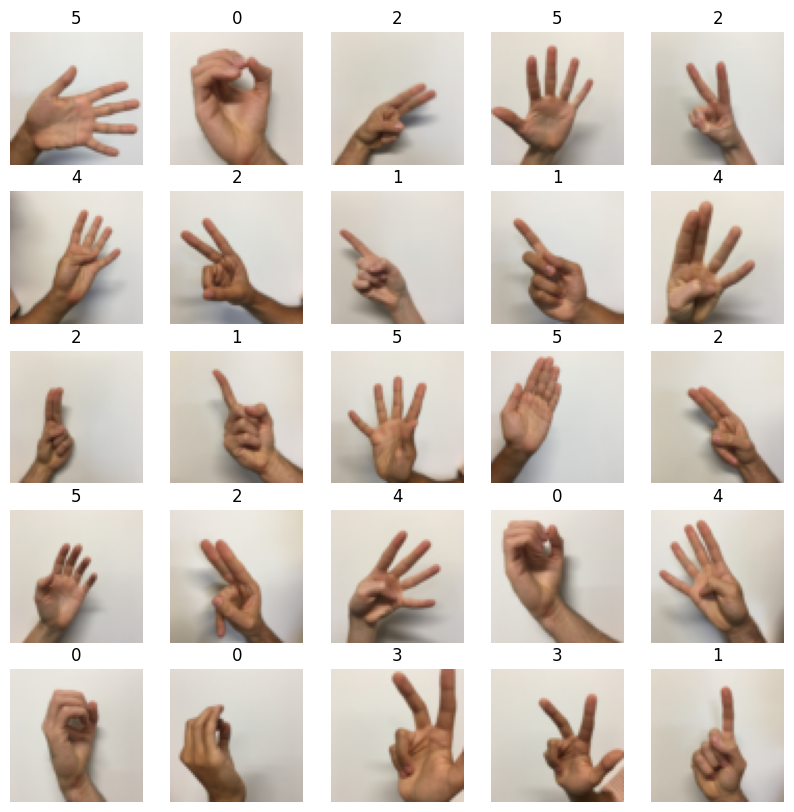

In [13]:
images_iter = iter(x_train)
labels_iter = iter(y_train)
plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(next(images_iter).numpy().astype("uint8"))
    plt.title(next(labels_iter).numpy().astype("uint8"))
    plt.axis("off")

In [14]:
def normalize(image):
    """Transform an image into a tensor of shape (64 * 64 * 3, ) and normalize its components.
    input: image (Tensor)
    returns: transformed tensor 
    """
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [-1,])
    return image

In [15]:
new_train = x_train.map(normalize)
new_test = x_test.map(normalize)

In [16]:
new_train.element_spec

TensorSpec(shape=(12288,), dtype=tf.float32, name=None)

In [17]:
print(next(iter(new_train)))

tf.Tensor([0.8901961  0.8627451  0.8392157  ... 0.8156863  0.81960785 0.81960785], shape=(12288,), dtype=float32)


In [18]:
def linear_function():
    """Implements a linear function: 
    - Initializes X to be a random tensor of shape (3,1)
    - Initializes W to be a random tensor of shape (4,3)
    - Initializes b to be a random tensor of shape (4,1)
    returns: result -- Y = WX + b 
    """
    np.random.seed(1)
    X = tf.constant(np.random.randn(3, 1), name="X")
    W = tf.constant(np.random.randn(4, 3), name="W")
    b = tf.constant(np.random.randn(4, 1), name="b")
    Y = tf.add(tf.matmul(W, X), b)
    return Y

In [19]:
def sigmoid(z):    
    """Computes the sigmoid of z.
    - z -- input value, scalar or vector
    returns: a -- (tf.float32) the sigmoid of z
    """
    z = tf.cast(z, tf.float32)
    a = tf.keras.activations.sigmoid(z)
    return a

In [20]:
def one_hot_matrix(label, C=6):
    """Computes the one hot encoding for a single label
    - label --  (int) Categorical labels
    - C --  (int) Number of different classes that label can take    
    returns: one_hot -- tf.Tensor A single-column matrix with the one hot encoding.
    """
    one_hot = tf.reshape(tf.one_hot(label, C, axis=0), shape=[C, ])    
    return one_hot

In [27]:
new_y_test = y_test.map(one_hot_matrix)
new_y_train = y_train.map(one_hot_matrix)

In [21]:
def initialize_parameters():
    """Initializes parameters to build a neural network with TensorFlow. The shapes are:
        W1 : [25, 12288]
        b1 : [25, 1]
        W2 : [12, 25]
        b2 : [12, 1]
        W3 : [6, 12]
        b3 : [6, 1]
    
    returns: parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    initializer = tf.keras.initializers.GlorotNormal(seed=1)   
    W1 = tf.Variable(initializer(shape=(25, 12288)))
    b1 = tf.Variable(initializer(shape=(25, 1)))
    W2 = tf.Variable(initializer(shape=(12, 25)))
    b2 = tf.Variable(initializer(shape=(12, 1)))
    W3 = tf.Variable(initializer(shape=(6, 12)))
    b3 = tf.Variable(initializer(shape=(6, 1)))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [23]:
def forward_propagation(X, parameters):
    """Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    returns: Z3 -- the output of the last LINEAR unit
    """
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.math.add(tf.linalg.matmul(W1, X), b1)
    A1 = tf.keras.activations.relu(Z1)
    Z2 = tf.math.add(tf.linalg.matmul(W2, A1), b2)
    A2 = tf.keras.activations.relu(Z2)
    Z3 = tf.math.add(tf.linalg.matmul(W3, A2), b3)
    return Z3

In [24]:
def compute_total_loss(logits, labels):
    """Computes the total loss
    logits -- output of forward propagation (output of the last LINEAR unit), of shape (6, num_examples)
    labels -- "true" labels vector, same shape as Z3
    
    returns: total_loss - Tensor of the total loss value
    """
    logits_transposed = tf.transpose(logits)
    labels_transposed = tf.transpose(labels)
    
    total_loss = tf.reduce_sum(
        tf.keras.losses.categorical_crossentropy(labels_transposed, logits_transposed, from_logits=True)
    )
    return total_loss

In [25]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    
    """Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 10 epochs
    
    returns: parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    costs = []                                        # To keep track of the cost
    train_acc = []
    test_acc = []
    
    parameters = initialize_parameters()

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    optimizer = tf.keras.optimizers.Adam(learning_rate)
    
    # The CategoricalAccuracy will track the accuracy for this multiclass problem
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    dataset = tf.data.Dataset.zip((X_train, Y_train))
    test_dataset = tf.data.Dataset.zip((X_test, Y_test))
    
    # We can get the number of elements of a dataset using the cardinality method
    m = dataset.cardinality().numpy()
    
    minibatches = dataset.batch(minibatch_size).prefetch(8)
    test_minibatches = test_dataset.batch(minibatch_size).prefetch(8)
    #X_train = X_train.batch(minibatch_size, drop_remainder=True).prefetch(8)# <<< extra step    
    #Y_train = Y_train.batch(minibatch_size, drop_remainder=True).prefetch(8) # loads memory faster 

    # training loop
    for epoch in range(num_epochs):

        epoch_total_loss = 0.
        
        # We need to reset object to start measuring from 0 the accuracy each epoch
        train_accuracy.reset_states()
        
        for (minibatch_X, minibatch_Y) in minibatches:
            
            with tf.GradientTape() as tape:
                # 1. predict
                Z3 = forward_propagation(tf.transpose(minibatch_X), parameters)

                # 2. loss
                minibatch_total_loss = compute_total_loss(Z3, tf.transpose(minibatch_Y))

            # We accumulate the accuracy of all the batches
            train_accuracy.update_state(minibatch_Y, tf.transpose(Z3))
            
            trainable_variables = [W1, b1, W2, b2, W3, b3]
            grads = tape.gradient(minibatch_total_loss, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables))
            epoch_total_loss += minibatch_total_loss
        
        # We divide the epoch total loss over the number of samples
        epoch_total_loss /= m

        # Print the cost every 10 epochs
        if print_cost == True and epoch % 10 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_total_loss))
            print("Train accuracy:", train_accuracy.result())
            
            # We evaluate the test set every 10 epochs to avoid computational overhead
            for (minibatch_X, minibatch_Y) in test_minibatches:
                Z3 = forward_propagation(tf.transpose(minibatch_X), parameters)
                test_accuracy.update_state(minibatch_Y, tf.transpose(Z3))
            print("Test_accuracy:", test_accuracy.result())

            costs.append(epoch_total_loss)
            train_acc.append(train_accuracy.result())
            test_acc.append(test_accuracy.result())
            test_accuracy.reset_states()


    return parameters, costs, train_acc, test_acc

In [28]:
parameters, costs, train_acc, test_acc = model(new_train, new_y_train, new_test, new_y_test, num_epochs=100)

Cost after epoch 0: 1.830244
Train accuracy: tf.Tensor(0.17037037, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.2, shape=(), dtype=float32)
Cost after epoch 10: 1.552391
Train accuracy: tf.Tensor(0.35925925, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.30833334, shape=(), dtype=float32)
Cost after epoch 20: 1.347617
Train accuracy: tf.Tensor(0.5074074, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.44166666, shape=(), dtype=float32)
Cost after epoch 30: 1.162812
Train accuracy: tf.Tensor(0.61388886, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.51666665, shape=(), dtype=float32)
Cost after epoch 40: 1.035599
Train accuracy: tf.Tensor(0.65833336, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.55833334, shape=(), dtype=float32)
Cost after epoch 50: 0.946474
Train accuracy: tf.Tensor(0.6814815, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.6166667, shape=(), dtype=float32)
Cost after epoch 60: 0.879669
Train accuracy: tf.Tensor(0.70555556, shape=(), dty

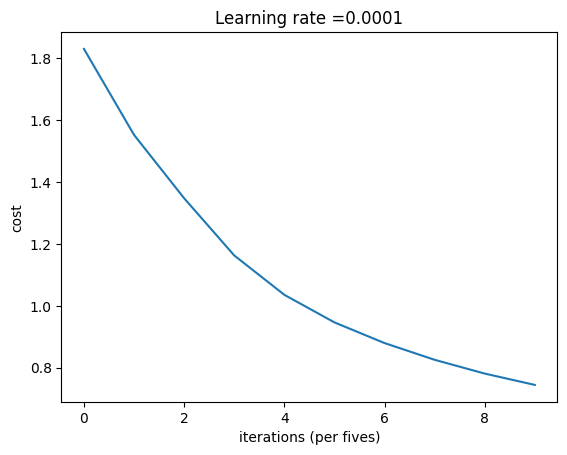

In [29]:
# plot the cost
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
plt.show()

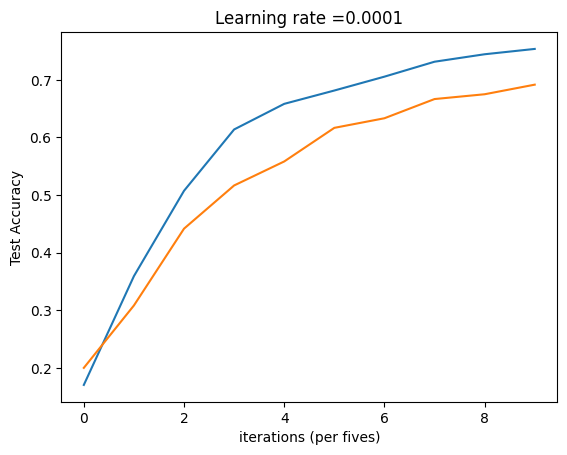

In [30]:
# plot the train accuracy
plt.plot(np.squeeze(train_acc))
plt.ylabel('Train Accuracy')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
# plot the test accuracy
plt.plot(np.squeeze(test_acc))
plt.ylabel('Test Accuracy')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
plt.show()